# Find the stimuli that maximally differentiates LN model from the Convnet trained on natural scenes

In [1]:
import numpy as np
from os.path import expanduser, join
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
import deepretina.visualizations as viz
from deepretina.utils import mksavedir
from deepretina.preprocessing import datagen, loadexpt
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.optimize import minimize
from numpy.linalg import norm
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


### Filenames and data directories

In [2]:
architecture_filename = 'architecture.json'
#whitenoise_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-08 15.42.33 convnet/')
#whitenoise_weight_filename = 'epoch018_iter01300_weights.h5' # .63 cc on held-out
naturalscenes_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-07 16.52.44 convnet/')
naturalscenes_weight_filename = 'epoch038_iter02700_weights.h5' # .53 cc on held-out
ln_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-11-08 04.41.18 LN/')
ln_weight_filename = 'epoch010_iter00750_weights.h5' # .468 cc on held-out

## Load convnet trained on natural scenes

In [3]:
naturalscenes_architecture_data = open(naturalscenes_data_dir + architecture_filename, 'r')
naturalscenes_architecture_string = naturalscenes_architecture_data.read()
naturalscenes_model = model_from_json(naturalscenes_architecture_string)
naturalscenes_model.load_weights(naturalscenes_data_dir + naturalscenes_weight_filename)

## Load LN model

In [4]:
ln_architecture_data = open(ln_data_dir + architecture_filename, 'r')
ln_architecture_string = ln_architecture_data.read()
ln_model = model_from_json(ln_architecture_string)
ln_model.load_weights(ln_data_dir + ln_weight_filename)

# Define model separation and constraint

In [5]:
def model_separation(stimulus):
    stimulus = stimulus.reshape((1,40,50,50))
    ln_response = ln_model.predict(stimulus)[0][0]
    convnet_response = naturalscenes_model.predict(stimulus)[0][0]
    return -(convnet_response - ln_response)**2

In [6]:
constraint = {}
def unit_norm_constraint(stimulus):
    return (1 - norm(stimulus))**2
constraint['fun'] = unit_norm_constraint
constraint['type'] = 'eq'

# Unconstrained optimization

In [ ]:
initial_guess = np.random.randn(1*40*50*50)
res = minimize(model_separation, x0=initial_guess)

# Constrained optimization

In [7]:
initial_guess_two = np.random.randn(1*40*50*50)/300
res_constrained = minimize(model_separation, x0=initial_guess_two, constraints=constraint)

ValueError: GpuDownsampleFactorMax:Was not able to allocate output!
Apply node that caused the error: GpuDownsampleFactorMax{(2, 2),True}(GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)].0)
Toposort index: 21
Inputs types: [CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 8, 50, 50)]
Inputs strides: [(0, 3844, 62, 1)]
Inputs values: ['not shown']
Outputs clients: [[GpuReshape{2}(GpuDownsampleFactorMax{(2, 2),True}.0, MakeVector{dtype='int64'}.0)]]

Debugprint of the apply node: 
GpuDownsampleFactorMax{(2, 2),True} [@A] <CudaNdarrayType(float32, 4D)> ''   
 |GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)] [@B] <CudaNdarrayType(float32, 4D)> ''   
   |CudaNdarrayConstant{[[[[ 2.08915925]]]]} [@C] <CudaNdarrayType(float32, (True, True, True, True))>
   |GpuSubtensor{::, ::, int64:int64:, int64:int64:} [@D] <CudaNdarrayType(float32, 4D)> ''   
   | |GpuCorrMM_gradInputs{valid, (1, 1)} [@E] <CudaNdarrayType(float32, 4D)> ''   
   | | |GpuContiguous [@F] <CudaNdarrayType(float32, 4D)> ''   
   | | | |GpuDimShuffle{1,0,2,3} [@G] <CudaNdarrayType(float32, 4D)> ''   
   | | |   |<CudaNdarrayType(float32, 4D)> [@H] <CudaNdarrayType(float32, 4D)>
   | | |GpuContiguous [@I] <CudaNdarrayType(float32, 4D)> ''   
   | |   |GpuFromHost [@J] <CudaNdarrayType(float32, 4D)> ''   
   | |     |<TensorType(float32, 4D)> [@K] <TensorType(float32, 4D)>
   | |Constant{6} [@L] <int64>
   | |ScalarFromTensor [@M] <int64> ''   
   | | |Elemwise{add,no_inplace} [@N] <TensorType(int64, scalar)> ''   
   | |   |TensorConstant{6} [@O] <TensorType(int64, scalar)>
   | |   |Shape_i{2} [@P] <TensorType(int64, scalar)> ''   
   | |     |<TensorType(float32, 4D)> [@K] <TensorType(float32, 4D)>
   | |Constant{6} [@L] <int64>
   | |ScalarFromTensor [@Q] <int64> ''   
   |   |Elemwise{add,no_inplace} [@R] <TensorType(int64, scalar)> ''   
   |     |TensorConstant{6} [@O] <TensorType(int64, scalar)>
   |     |Shape_i{3} [@S] <TensorType(int64, scalar)> ''   
   |       |<TensorType(float32, 4D)> [@K] <TensorType(float32, 4D)>
   |GpuDimShuffle{x,0,x,x} [@T] <CudaNdarrayType(float32, (True, False, True, True))> ''   
     |<CudaNdarrayType(float32, vector)> [@U] <CudaNdarrayType(float32, vector)>

Storage map footprint:
 - <TensorType(float32, 4D)>, Input, Shape: (1, 40, 50, 50), ElemSize: 4 Byte(s), TotalSize: 400000 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (5000, 16), ElemSize: 4 Byte(s), TotalSize: 320000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (8, 40, 13, 13), ElemSize: 4 Byte(s), TotalSize: 216320 Byte(s)
 - GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)].0, Shape: (1, 8, 50, 50), ElemSize: 4 Byte(s), TotalSize: 80000 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (16,), ElemSize: 4 Byte(s), TotalSize: 64 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (16, 1), ElemSize: 4 Byte(s), TotalSize: 64 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (8,), ElemSize: 4 Byte(s), TotalSize: 32 Byte(s)
 - TensorConstant{62}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{8}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{68}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - CudaNdarrayConstant{[[[[-0.00026369]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 2.08915925]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 1016598.0 Byte(s) 0.001 GB
 TotalSize inputs: 936566.0 Byte(s) 0.001 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

# Projective Gradient Descent

In [5]:
def model_separation_low_rank(stimulus):
    stim = np.outer(stimulus[:40], stimulus[40:])
    stimulus = stim.reshape((1,40,50,50))
    ln_response = ln_model.predict(stimulus)[0][0]
    convnet_response = naturalscenes_model.predict(stimulus)[0][0]
    return -(convnet_response - ln_response)**2

In [6]:
def pgd(fun, x0, maxiter=1000, learning_rate=1e-1, low_rank=True):
    '''
    Projective gradient descent with a fixed constraint to force
    stimuli to have unit norm.
    
    Parameters
    ----------
    fun          objective function
    x0           initial guess; should be 1d
    '''    
    # CONSTANTS
    epsilon = 1e-5 # amount to change x0
    if low_rank:
        full_x0 = np.outer(x0[:40], x0[40:])
        full_x0 = full_x0.reshape((1,40,50,50))
        num_dims = np.prod(full_x0.shape)
    else:
        num_dims = np.prod(x0.shape)
    save_dir = mksavedir(prefix='Maximal Differentiated Stimuli')
    
    # INITIALIZE GRADIENTS AND SOLUTION
    grads = np.zeros_like(x0)
    x = np.copy(x0)
    
    # RUN PGD
    for i in range(maxiter):
        for idp, param in enumerate(x):
            # compute two-sided numerical gradient
            plus_x = np.copy(x)
            plus_x[idp] += epsilon
            minus_x = np.copy(x)
            minus_x[idp] -= epsilon
            
            # evaluate objective function
            plus_res = fun(plus_x)
            minus_res = fun(minus_x)
            
            # store gradient
            grads[idp] = (plus_res - minus_res)/2.

        # make gradient update
        x -= learning_rate * grads

        # project this update onto the constraint space (unit norm)
        if low_rank:
            full_x = np.outer(x[:40], x[40:])
            full_x = full_x.reshape((1,40,50,50))
            full_x /= norm(full_x)
            space, time = ft.decompose(full_x[0])
            x[:40] = time
            x[40:] = space.flatten()
        else:
            x /= norm(x)
        
        if i % 10 == 0:
            print 'Iteration %d of %d. Objective function is %f.' %(i,maxiter,plus_res)
            filename = 'differentiated_stimuli_iter_%d.h5' %i
            f = h5py.File(join(save_dir, filename), 'w')
            f.create_dataset('stimulus', data=x)
            f.close()
            
            fig_filename = 'differentiated_stimuli_iter_%d.png' %i
            plt.imshow(x[40:].reshape((50,50)))
            plt.grid('off')
            plt.savefig(join(save_dir, fig_filename))
    
    return x

Iteration 0 of 100. Objective function is -19.406205.
Iteration 10 of 100. Objective function is -1.609551.
Iteration 20 of 100. Objective function is -1.609580.
Iteration 30 of 100. Objective function is -1.609608.
Iteration 40 of 100. Objective function is -1.609637.
Iteration 50 of 100. Objective function is -1.609668.
Iteration 60 of 100. Objective function is -1.609699.
Iteration 70 of 100. Objective function is -1.609729.
Iteration 80 of 100. Objective function is -1.609758.
Iteration 90 of 100. Objective function is -1.609789.


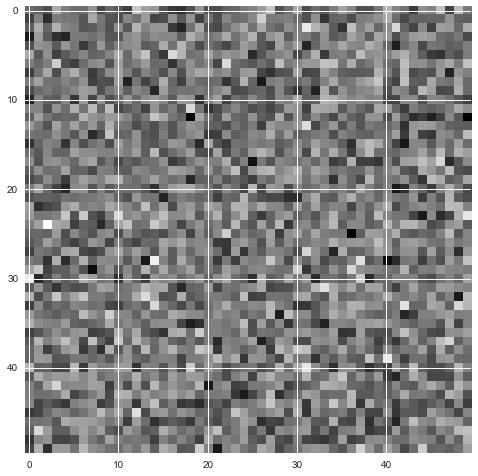

In [24]:
# initial_guess = np.random.randn(1*40*50*50).astype('float32')
# x = pgd(model_separation, initial_guess, maxiter=100)
initial_guess = np.random.randn(1*40 + 50*50).astype('float32')
x = pgd(model_separation_low_rank, initial_guess, maxiter=100)

Iteration 0 of 1000. Objective function is -1.609817.
Iteration 10 of 1000. Objective function is -1.609849.
Iteration 20 of 1000. Objective function is -1.609880.
Iteration 30 of 1000. Objective function is -1.609909.
Iteration 40 of 1000. Objective function is -1.609939.
Iteration 50 of 1000. Objective function is -1.609969.
Iteration 60 of 1000. Objective function is -1.610000.
Iteration 70 of 1000. Objective function is -1.610029.
Iteration 80 of 1000. Objective function is -1.610056.
Iteration 90 of 1000. Objective function is -1.610084.
Iteration 100 of 1000. Objective function is -1.610115.
Iteration 110 of 1000. Objective function is -1.610145.
Iteration 120 of 1000. Objective function is -1.610175.
Iteration 130 of 1000. Objective function is -1.610204.
Iteration 140 of 1000. Objective function is -1.610236.
Iteration 150 of 1000. Objective function is -1.610266.
Iteration 160 of 1000. Objective function is -1.610296.
Iteration 170 of 1000. Objective function is -1.610326.
Ite

KeyboardInterrupt: 

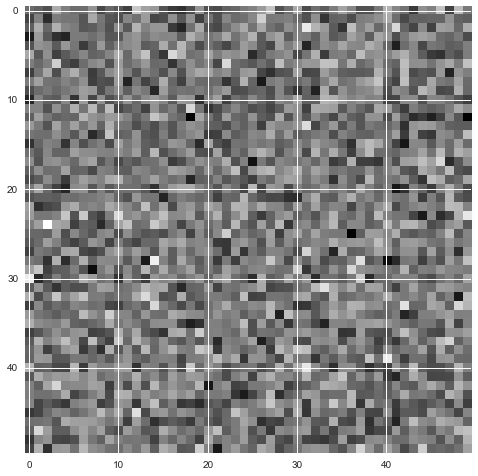

In [25]:
# initial_guess = np.random.randn(1*40*50*50).astype('float32')
# x = pgd(model_separation, initial_guess, maxiter=100)
initial_guess = x
x = pgd(model_separation_low_rank, initial_guess, maxiter=1000)

## Crank up the learning rate

#### Load last x

In [7]:
stim_name = 'differentiated_stimuli_iter_640.h5'
stim_path = expanduser('~/Dropbox/deep-retina/saved/lane.local.lmcintosh/2015-11-12 01.42.29 Maximal Differentiated Stimuli/')
f = h5py.File(join(stim_path, stim_name), 'r')
initial_guess = np.copy(f['stimulus'])
initial_guess.shape

(2540,)

Iteration 0 of 100. Objective function is -1.611749.
Iteration 10 of 100. Objective function is -1.612031.
Iteration 20 of 100. Objective function is -1.612286.
Iteration 30 of 100. Objective function is -1.612554.
Iteration 40 of 100. Objective function is -1.612837.
Iteration 50 of 100. Objective function is -1.613122.


KeyboardInterrupt: 

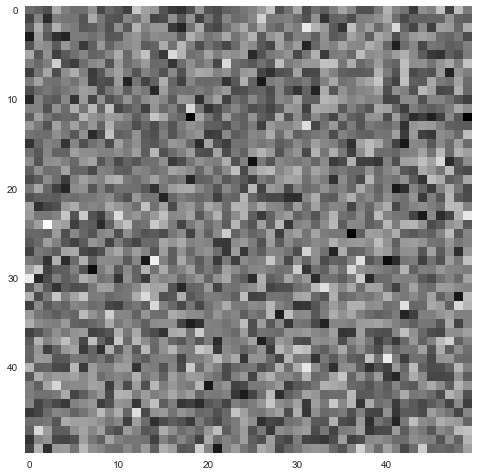

In [9]:
x = pgd(model_separation_low_rank, initial_guess, maxiter=100, learning_rate=0.9)

Iteration 0 of 100. Objective function is -1.611749.
Iteration 10 of 100. Objective function is -1.612390.
Iteration 20 of 100. Objective function is -1.612959.
Iteration 30 of 100. Objective function is -1.613548.
Iteration 40 of 100. Objective function is -1.614151.
Iteration 50 of 100. Objective function is -1.614724.
Iteration 60 of 100. Objective function is -1.615360.
Iteration 70 of 100. Objective function is -1.615938.
Iteration 80 of 100. Objective function is -1.616546.
Iteration 90 of 100. Objective function is -1.617165.


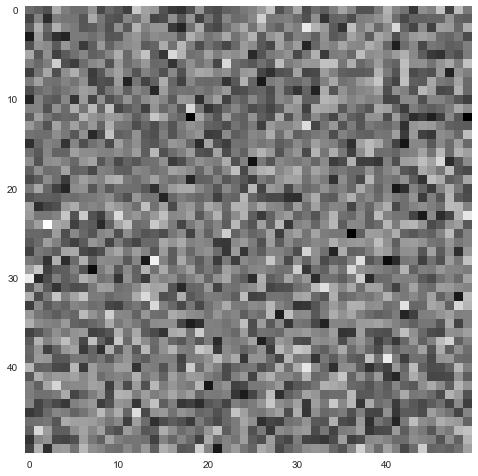

In [10]:
x = pgd(model_separation_low_rank, initial_guess, maxiter=100, learning_rate=2.)